In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.9 MB/s eta 0:00:00


In [2]:
import pandas as pd

In [3]:
data=pd.read_csv('diabetes.csv')
data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,102.0,52.0,19.664000,68.792000,25.1,0.078,21,0
1,6,87.0,80.0,19.664000,68.792000,23.2,0.084,32,0
2,2,90.0,70.0,17.000000,68.792000,27.3,0.085,22,0
3,6,92.0,62.0,32.000000,126.000000,32.0,0.085,46,0
4,2,125.0,60.0,20.000000,140.000000,33.8,0.088,31,0
5,1,173.0,74.0,22.164179,100.335821,36.8,0.088,38,1
6,0,117.0,80.0,31.000000,53.000000,45.2,0.089,24,0
7,2,114.0,68.0,22.000000,68.792000,28.7,0.092,25,0
8,9,57.0,80.0,37.000000,68.792000,32.8,0.096,41,0
9,1,124.0,74.0,36.000000,68.792000,27.8,0.100,30,0


In [4]:
data.dtypes

Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [5]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

some of the values in the dataset attributes are labeled as zero like the value of glucose and blood pressure can't be zero we need to find and tackle those zeros with mean

In [6]:
print("No. of Zero Values in Glucose ", data[data['Glucose']==0].shape[0])
print("No. of Zero Values in Blood Pressure ", data[data['BloodPressure']==0].shape[0])
print("No. of Zero Values in SkinThickness ", data[data['SkinThickness']==0].shape[0])
print("No. of Zero Values in Insulin ", data[data['Insulin']==0].shape[0])
print("No. of Zero Values in BMI ", data[data['BMI']==0].shape[0])

No. of Zero Values in Glucose  0
No. of Zero Values in Blood Pressure  0
No. of Zero Values in SkinThickness  0
No. of Zero Values in Insulin  0
No. of Zero Values in BMI  0


At the same time there is also an class
imbalance


In [7]:
N, P = data['Outcome'].value_counts()
print('Negative (0):', N)
print('Positive (1):', P)

Negative (0): 500
Positive (1): 268


In [8]:
import warnings
warnings.filterwarnings('ignore')

Pair Plot with KDE and Correlation Values

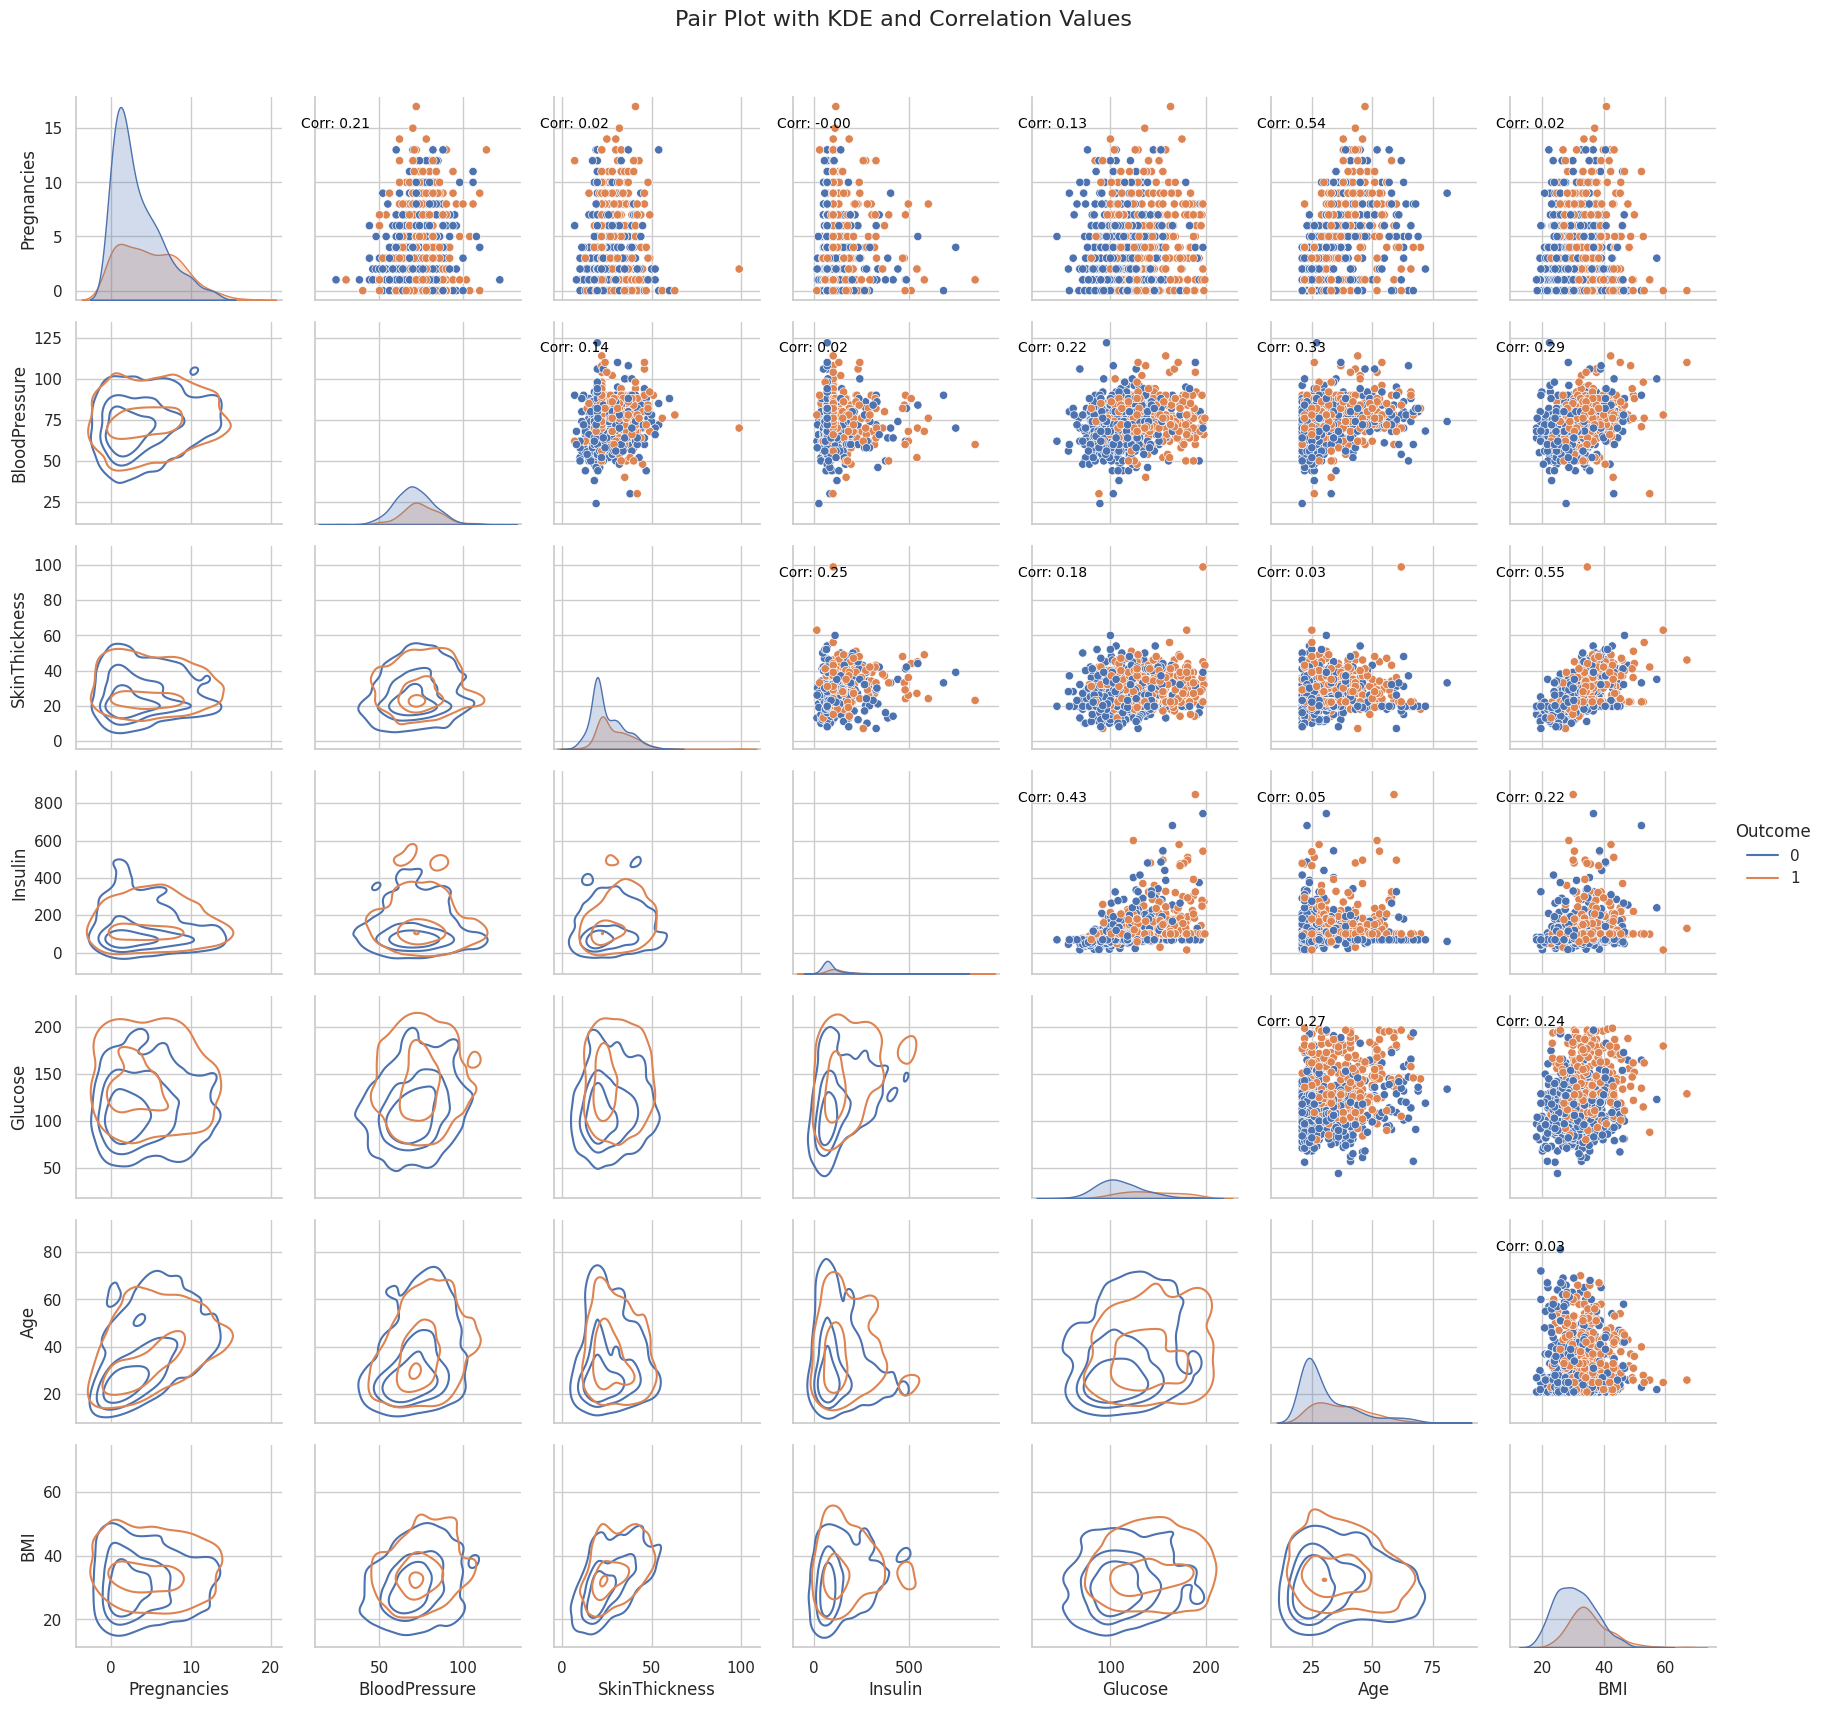

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


selected_features = data[['Pregnancies','BloodPressure', 'SkinThickness', 'Insulin', 'Glucose', 'Age', 'BMI', 'Outcome']]


sns.set(style="whitegrid")
g = sns.PairGrid(selected_features, hue='Outcome')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, shade=True)
g.map_lower(sns.kdeplot, levels=4, cmap="Blues_d")
g.add_legend()


corr_matrix = selected_features.corr()
for i, j in zip(*plt.np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].annotate(f'Corr: {corr_matrix.iloc[i, j]:.2f}', (0.1, 0.85), xycoords='axes fraction', ha='center', fontsize=10, color='black')


g.fig.subplots_adjust(top=0.93)
g.fig.suptitle("Pair Plot with KDE and Correlation Values", fontsize=16)

plt.show()


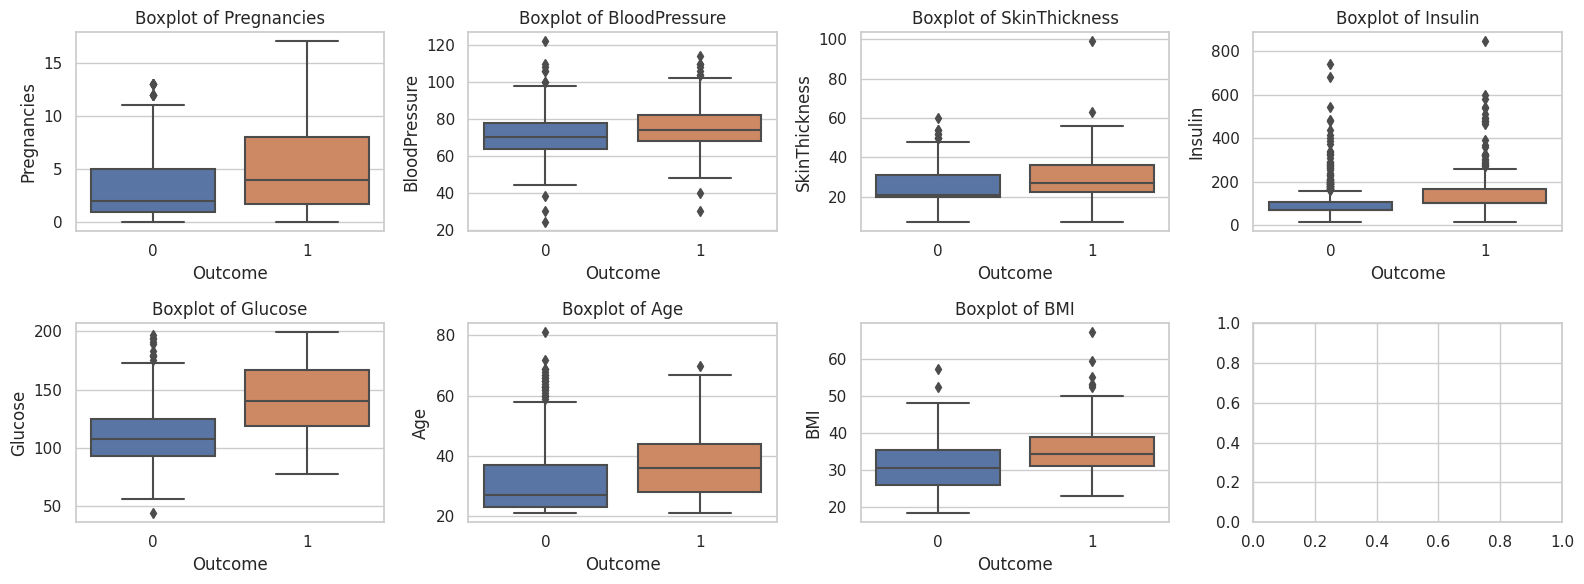

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_features = data[['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'Glucose', 'Age', 'BMI', 'Outcome']]

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
for i, feature in enumerate(selected_features.columns[:-1]):
    sns.boxplot(x='Outcome', y=feature, data=selected_features, ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()


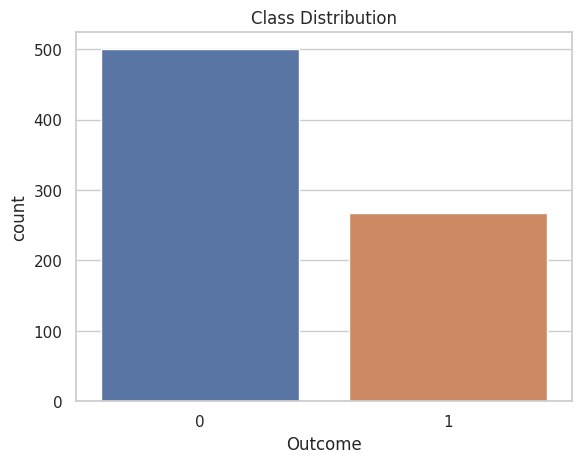

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=data, x='Outcome')
plt.title("Class Distribution")
plt.show()

Tackle the zero values in the attributes may be lead to majority classbias                     Assumptions:

Binary classification problem with two classes: Majority class (label 0) and Minority class (label 1).
The dataset is imbalanced, with the number of instances in the majority class (M) being twice the number of instances in the minority class (m), i.e., M = 2m.
Mean imputation is performed by replacing missing (zero) values with the mean (μ) of the entire dataset.
Proof:
Let P(class=1) represent the probability of an instance belonging to the minority class (label 1) before mean imputation.

Initial minority class distribution:
P(class=1) = m / (m + M)

After mean imputation, all instances in the dataset are assigned the same mean value μ. Therefore, the new class distribution for the minority class becomes:

New minority class distribution:
P(class=1) = (m + M) / (m + M)

Since M = 2m (due to the class imbalance), we can substitute:

P(class=1) = (m + 2m) / (m + 2m)

P(class=1) = 3m / (3m)

Now, we can simplify:

P(class=1) = 1

The final result demonstrates that after mean imputation, the new distribution for the minority class becomes 1, meaning that all instances in the minority class are classified as the minority class. This is a clear illustration of how mean imputation introduces a significant bias in favor of the majority class, as it results in all instances in the minority class being assigned the same value and, therefore, all being classified as the minority class.


So it is important to fill the minority class instances with only minority class data and majority class instances with majority class data

In [12]:
data[['BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data.groupby('Outcome')[['BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].transform(lambda x: x.replace(0, x.mean()))

In [13]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy import interp
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

for dealing with the outliers

In [14]:
def Manual(data, numeric_columns=None, outlier_factor=1.5, keep_outliers=False):
    data_copy = data.copy()

    if numeric_columns is None:
        numeric_columns = data_copy.select_dtypes(include=['number']).columns

    for col in numeric_columns:
        Q1 = data_copy[col].quantile(0.25)
        Q3 = data_copy[col].quantile(0.75)
        IQR = Q3 - Q1


        lower_bound = Q1 - outlier_factor * IQR
        upper_bound = Q3 + outlier_factor * IQR

        if keep_outliers:
            data_copy = data_copy[(data_copy[col] < lower_bound) | (data_copy[col] > upper_bound)]
        else:
            data_copy = data_copy[(data_copy[col] >= lower_bound) & (data_copy[col] <= upper_bound)]

    return data_copy


In [15]:
data = Manual(data)
data = data.reset_index(drop=True)

data[['BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data.groupby('Outcome')[['BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].transform(lambda x: x.replace(0, x.mean()))

X_Data = data.iloc[:, [1]+[5]+[0]+[6]+[2]+[4]]
Y_Lavel = data.iloc[:, -1]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()


custom_weights = [1.0, 2.0, 1.0, 1.0, 1.0]

X_Data = data.drop('Outcome', axis=1).values
X_Data[:, 1] = X_Data[:, 1] * custom_weights[1]  # Apply the custom weight to 'Attribute 1'
X_Data = sc.fit_transform(X_Data)

#for feature selection
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_Data, Y_Lavel)
X_Data = selector.transform(X_Data)

#for class imbalance
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=69)
X_Data, Y_Lavel = ros.fit_resample(X_Data, Y_Lavel)

n_splits = 30
kf = KFold(n_splits=n_splits, shuffle=True, random_state=69)

FOR PLOTTING AND VISULIZATION


In [16]:
import matplotlib.pyplot as plt

def plot_Current_ROC(fpr, tpr, iterator, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'Fold {iterator + 1} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
def average_ROC(mean_fpr, tprs, aucs_kNN):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs_kNN)
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

def average_performance(aucs_kNN, accuracy, TP, TN, FP, FN):
    mean_auc = np.mean(aucs_kNN)
    mean_accuracy = np.mean(accuracy)
    mean_TP = np.mean(TP)
    mean_TN = np.mean(TN)
    mean_FP = np.mean(FP)
    mean_FN = np.mean(FN)

    print(f'Mean AUC: {mean_auc:.2f}')
    print(f'Mean Accuracy: {mean_accuracy:.2f}')
    print(f'Mean True Positives: {mean_TP:.2f}')
    print(f'Mean True Negatives: {mean_TN:.2f}')
    print(f'Mean False Positives: {mean_FP:.2f}')
    print(f'Mean False Negatives: {mean_FN:.2f}')

In [17]:
def metrics(y_true, y_pred, probas_):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    roc_auc = roc_auc_score(y_true, probas_[:, 1])

    fpr, tpr, _ = roc_curve(y_true, probas_[:, 1])

    return tn, fp, fn, tp, roc_auc, fpr, tpr

FOR STORING THE ACCAURACY WE ARE CREATING THE LIST

In [18]:
results = []

MODEL SELECTION

K NEAREST NEIGHBOUR

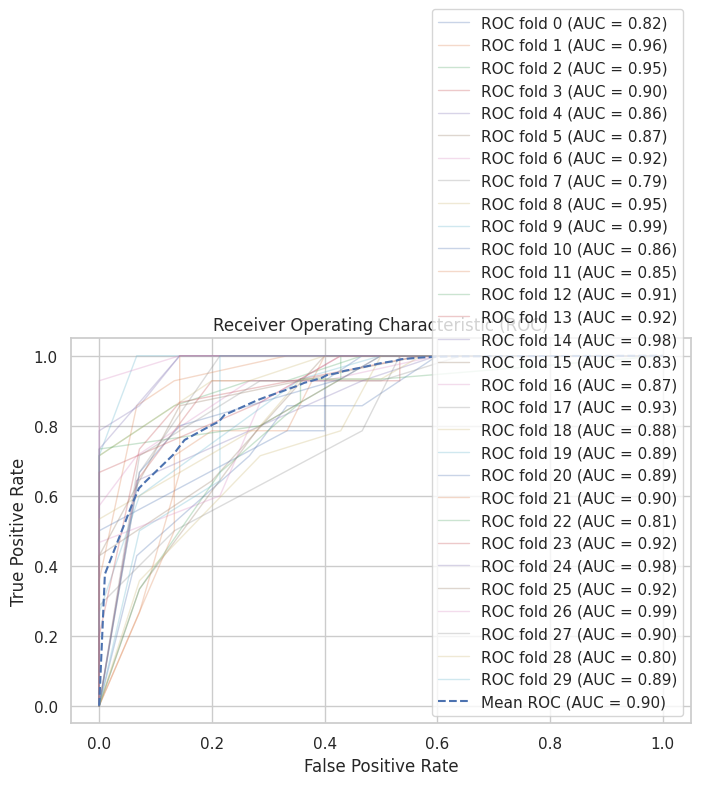

Accuracy (Avg. +/- Std.) is 0.806 +/- 0.073
Sensitivity (Avg. +/- Std.) is 0.893 +/- 0.070
Specificity (Avg. +/- Std.) is 0.718 +/- 0.121
Precision (Avg. +/- Std.) is 0.767 +/- 0.084
FOR (Avg. +/- Std.) is 0.126 +/- 0.079
DOR (Avg. +/- Std.) is inf +/- nan


In [19]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
from sklearn.neighbors import KNeighborsClassifier  # Import KNeighborsClassifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_knn = []  # Change this list for KNN
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    # Create and fit the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
    knn.fit(X_Train, Y_Train)

    y_pred_proba = knn.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_knn.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "KNN",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})


SUPPORT VECTOR MACHINE

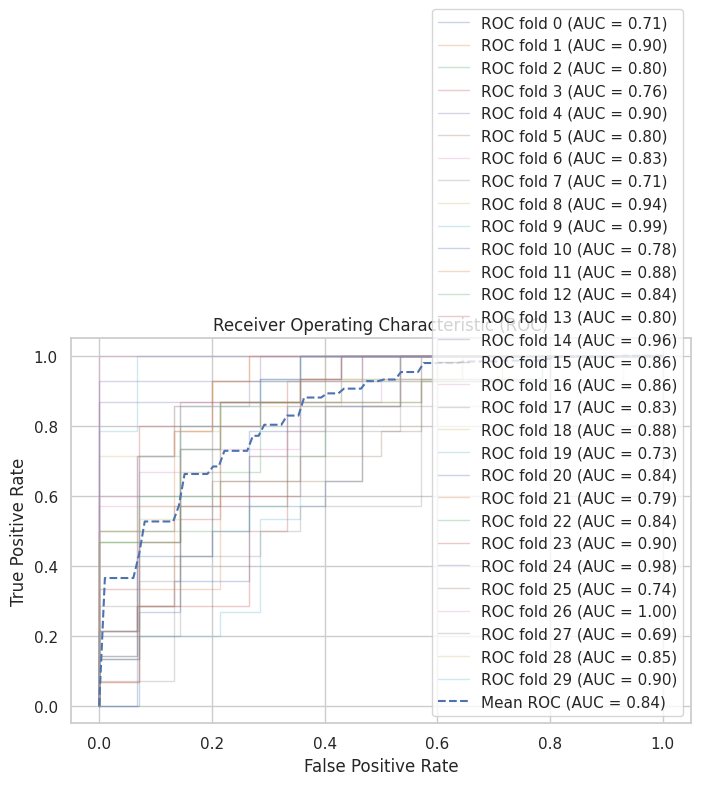

Accuracy (Avg. +/- Std.) is 0.759 +/- 0.101
Sensitivity (Avg. +/- Std.) is 0.745 +/- 0.120
Specificity (Avg. +/- Std.) is 0.774 +/- 0.140
Precision (Avg. +/- Std.) is 0.777 +/- 0.128
FOR (Avg. +/- Std.) is 0.243 +/- 0.098
DOR (Avg. +/- Std.) is inf +/- nan


In [20]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
from sklearn.svm import SVC  # Import the Support Vector Machine classifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_svm = []  # Change this list for SVM
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    # Create and fit the SVM classifier
    svm = SVC(probability=True, kernel='linear')  # You can adjust the kernel and other parameters
    svm.fit(X_Train, Y_Train)

    y_pred_proba = svm.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_svm.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "SUPPORT VECTOR MACHINE",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

NAVIES BAYES

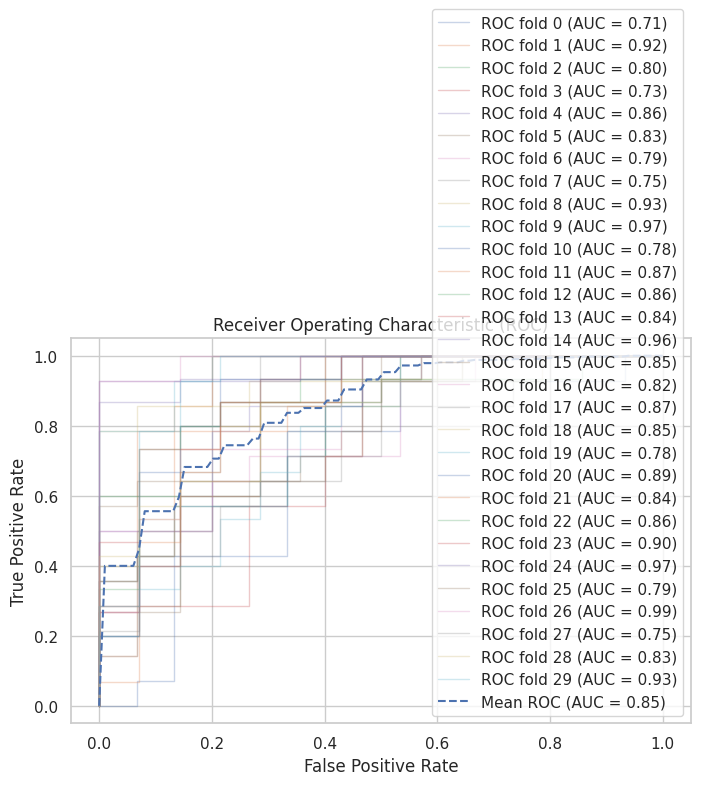

Accuracy (Avg. +/- Std.) is 0.765 +/- 0.089
Sensitivity (Avg. +/- Std.) is 0.757 +/- 0.091
Specificity (Avg. +/- Std.) is 0.774 +/- 0.139
Precision (Avg. +/- Std.) is 0.782 +/- 0.123
FOR (Avg. +/- Std.) is 0.238 +/- 0.078
DOR (Avg. +/- Std.) is inf +/- nan


In [21]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
from sklearn.naive_bayes import GaussianNB  # Import the Gaussian Naive Bayes classifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_nb = []  # Change this list for Naive Bayes
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    # Create and fit the Naive Bayes classifier
    nb = GaussianNB()  # Gaussian Naive Bayes for continuous data
    nb.fit(X_Train, Y_Train)

    y_pred_proba = nb.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_nb.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "NAVIES BAYES",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity":np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

DECISION TREE

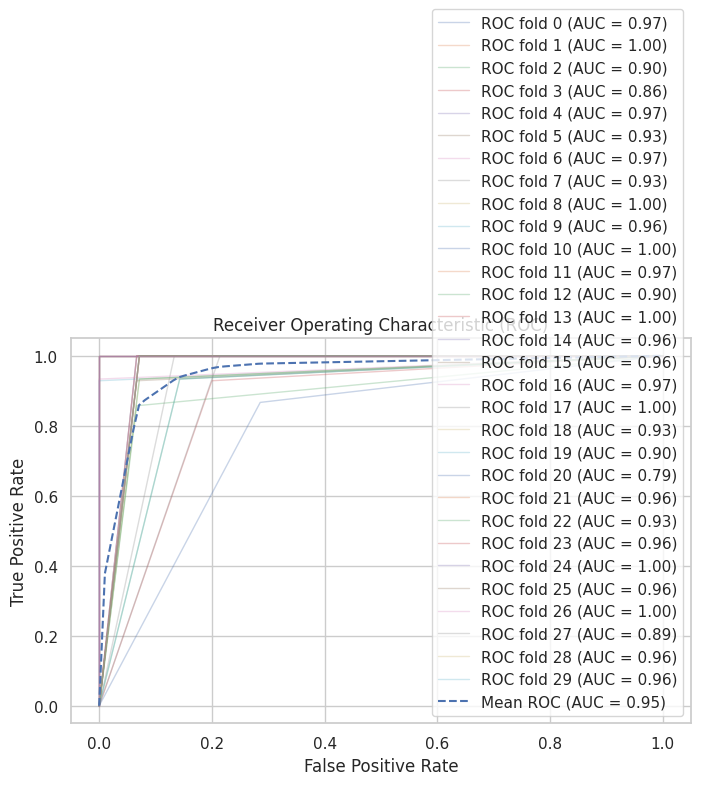

Accuracy (Avg. +/- Std.) is 0.950 +/- 0.047
Sensitivity (Avg. +/- Std.) is 0.973 +/- 0.042
Specificity (Avg. +/- Std.) is 0.928 +/- 0.069
Precision (Avg. +/- Std.) is 0.934 +/- 0.059
FOR (Avg. +/- Std.) is 0.029 +/- 0.045
DOR (Avg. +/- Std.) is inf +/- nan


In [22]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
from sklearn.tree import DecisionTreeClassifier  # Import the Decision Tree classifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_dt = []  # Change this list for Decision Tree
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    # Create and fit the Decision Tree classifier
    dt = DecisionTreeClassifier()  # You can adjust hyperparameters if needed
    dt.fit(X_Train, Y_Train)

    y_pred_proba = dt.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_dt.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "DECISION TREE",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

ENSEMBLE LEARNING TECHQUINES

ENSEMBLING FOR DECISON TREE AND K NEAREST NEIGHBOR

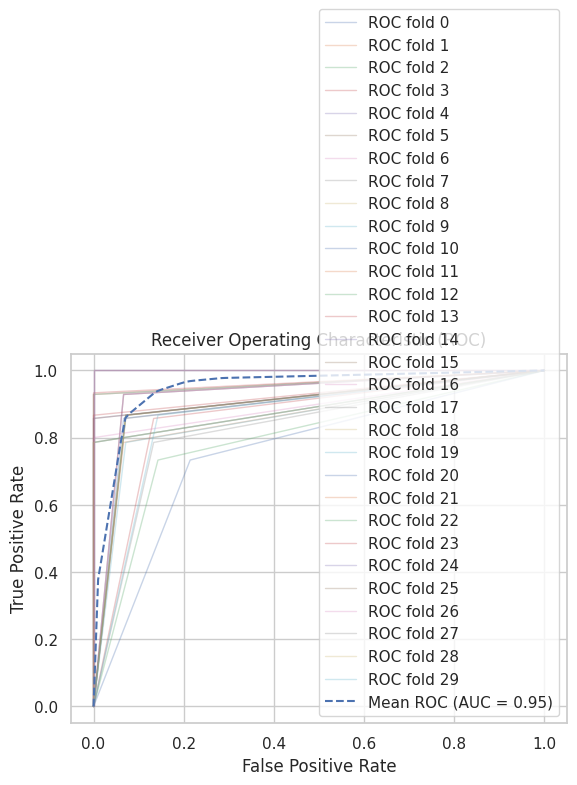

Accuracy (Avg. +/- Std.) is 0.907 +/- 0.056
Sensitivity (Avg. +/- Std.) is 0.866 +/- 0.073
Specificity (Avg. +/- Std.) is 0.949 +/- 0.057
Precision (Avg. +/- Std.) is 0.946 +/- 0.059
FOR (Avg. +/- Std.) is 0.122 +/- 0.065
DOR (Avg. +/- Std.) is inf +/- nan


In [23]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

n_splits = 30

Accuracy = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    # Create and fit the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
    knn.fit(X_Train, Y_Train)

    # Create and fit the Decision Tree classifier
    dt = DecisionTreeClassifier()  # You can adjust hyperparameters if needed
    dt.fit(X_Train, Y_Train)

    # Ensemble the classifiers using majority vote
    ensemble = VotingClassifier(estimators=[('knn', knn), ('dt', dt)], voting='hard')
    ensemble.fit(X_Train, Y_Train)
    y_pred_ensemble = ensemble.predict(X_Test)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, y_pred_ensemble)
    Accuracy.append(accuracy)

    # Calculate TP, TN, FP, FN
    tn, fp, fn, tp = confusion_matrix(Y_Test, y_pred_ensemble).ravel()

    # Calculate and store Sensitivity (sn), Specificity (sp), Precision (pr), FOR, and DOR
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    FOR_value = fn / (tn + fn)
    DOR_value = (tp * tn) / (fp * fn)

    sn.append(sensitivity)
    sp.append(specificity)
    pr.append(precision)
    FOR.append(FOR_value)
    DOR.append(DOR_value)

    fpr, tpr, thresholds = roc_curve(Y_Test, y_pred_ensemble)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d' % iterator)

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr = np.array(mean_tpr)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# Plot the mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
    "Model Algorithm Name": "DECISION TREE AND K NEAREST NEIGHBOR",
    "Accuracy": np.mean(Accuracy),
    "Sensitivity": np.mean(sn),
    "Specificity": np.mean(sp),
    "Precision": np.mean(pr),
    "FOR": np.mean(FOR),
    "DOR": np.mean(DOR),
})


RANDOM FOREST

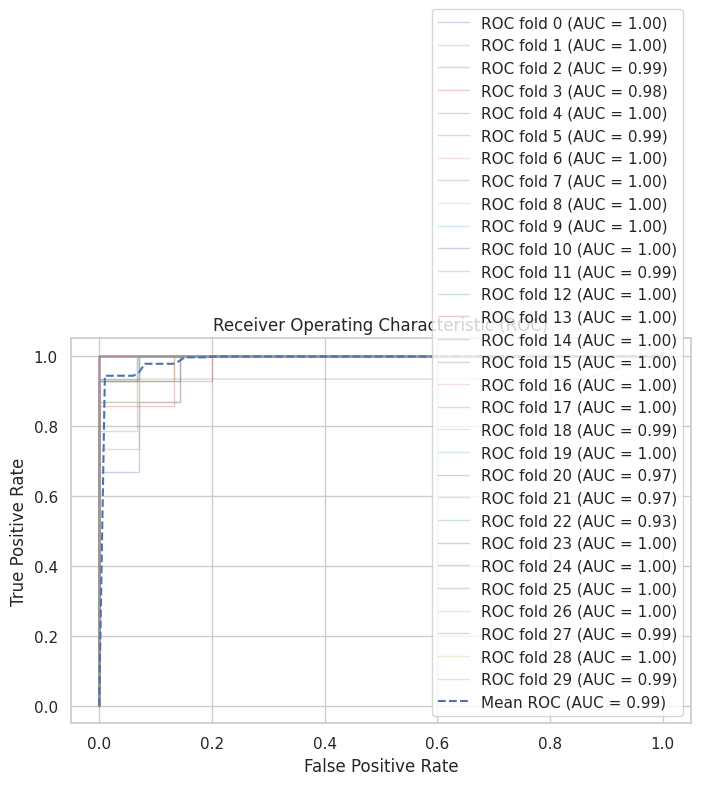

Accuracy (Avg. +/- Std.) is 0.948 +/- 0.038
Sensitivity (Avg. +/- Std.) is 0.984 +/- 0.029
Specificity (Avg. +/- Std.) is 0.912 +/- 0.072
Precision (Avg. +/- Std.) is 0.922 +/- 0.059
FOR (Avg. +/- Std.) is 0.016 +/- 0.030
DOR (Avg. +/- Std.) is inf +/- nan


In [24]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
from sklearn.ensemble import RandomForestClassifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_rf = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    # Create and fit the Random Forest classifier with additional parameters
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=69)

    rf.fit(X_Train, Y_Train)

    y_pred_proba = rf.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_rf.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "RANDOM FOREST",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

ADA BOOSTING

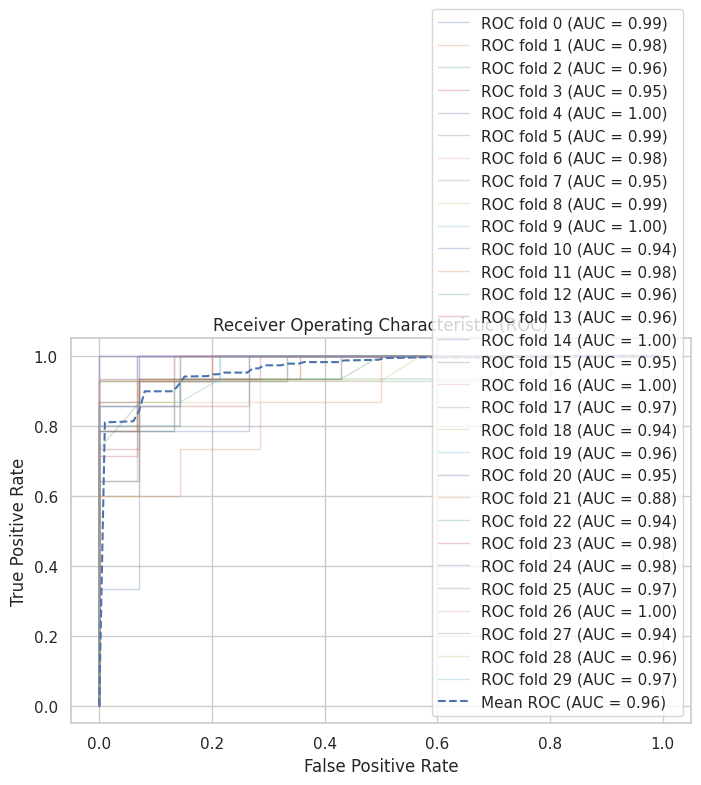

Accuracy (Avg. +/- Std.) is 0.878 +/- 0.067
Sensitivity (Avg. +/- Std.) is 0.944 +/- 0.061
Specificity (Avg. +/- Std.) is 0.812 +/- 0.115
Precision (Avg. +/- Std.) is 0.842 +/- 0.087
FOR (Avg. +/- Std.) is 0.062 +/- 0.063
DOR (Avg. +/- Std.) is inf +/- nan


In [25]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
from sklearn.ensemble import AdaBoostClassifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_adaboost = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    # Create and fit the AdaBoost classifier
    adaboost = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, random_state=69)  # Adjust hyperparameters as needed
    adaboost.fit(X_Train, Y_Train)

    y_pred_proba = adaboost.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_adaboost.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "ADA BOOSTING",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})


XG BOOSTING

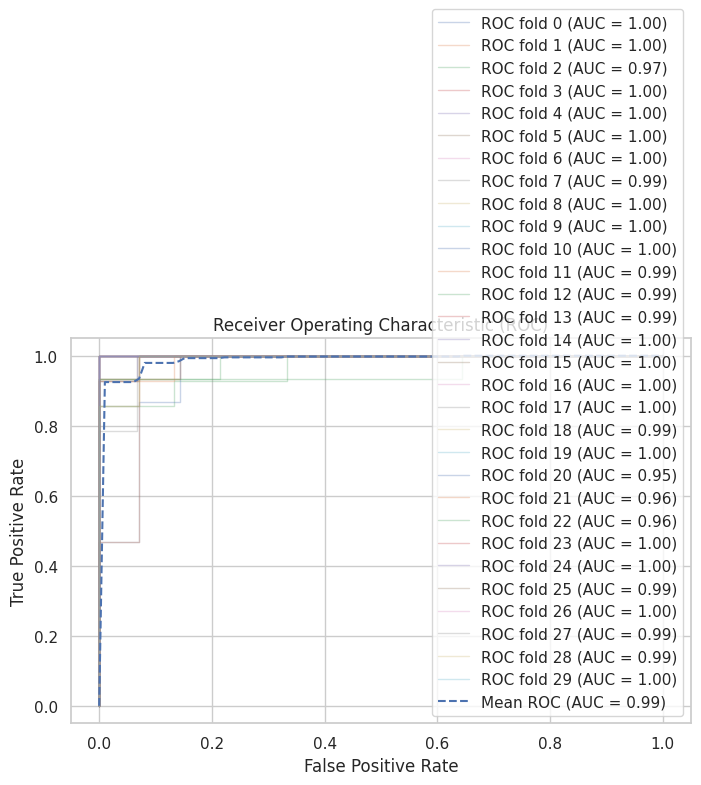

Accuracy (Avg. +/- Std.) is 0.951 +/- 0.043
Sensitivity (Avg. +/- Std.) is 0.968 +/- 0.047
Specificity (Avg. +/- Std.) is 0.934 +/- 0.068
Precision (Avg. +/- Std.) is 0.941 +/- 0.057
FOR (Avg. +/- Std.) is 0.032 +/- 0.046
DOR (Avg. +/- Std.) is inf +/- nan


In [26]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
import xgboost as xgb

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_xgboost = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    # Create and fit the XGBoost classifier
    xgboost = xgb.XGBClassifier(n_estimators=15000, learning_rate=0.09, max_depth=3, random_state=69)  # Adjust hyperparameters as needed
    xgboost.fit(X_Train, Y_Train)

    y_pred_proba = xgboost.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_xgboost.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "XG BOOSING",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})


CATEGORICAL BOOSTING

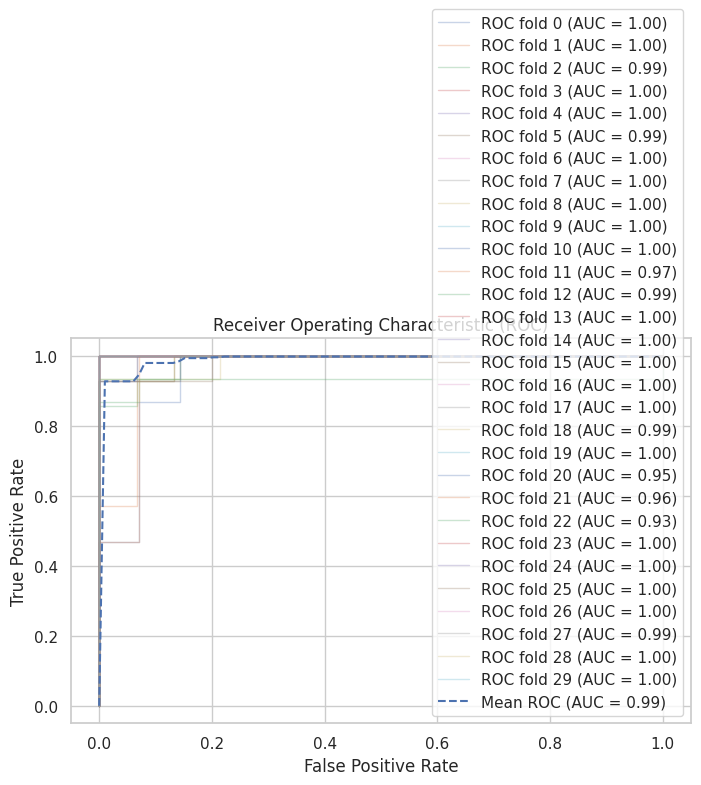

Accuracy (Avg. +/- Std.) is 0.957 +/- 0.034
Sensitivity (Avg. +/- Std.) is 0.974 +/- 0.043
Specificity (Avg. +/- Std.) is 0.940 +/- 0.057
Precision (Avg. +/- Std.) is 0.945 +/- 0.050
FOR (Avg. +/- Std.) is 0.025 +/- 0.040
DOR (Avg. +/- Std.) is inf +/- nan


In [27]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
from catboost import CatBoostClassifier
n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_catboost = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    catboost_params = {
        'iterations': 900,
        'learning_rate': 0.05,
        'depth': 5,
        'l2_leaf_reg': 3,
        'loss_function': 'Logloss',
        'verbose': 0,
        'random_seed': 69
    }

    clf = CatBoostClassifier(**catboost_params)
    clf.fit(X_Train, Y_Train)

    y_pred_proba = clf.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_catboost.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)


plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "CATEGORICAL BOOSTING",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})


XG AND CATEGORICAL BOOSTING

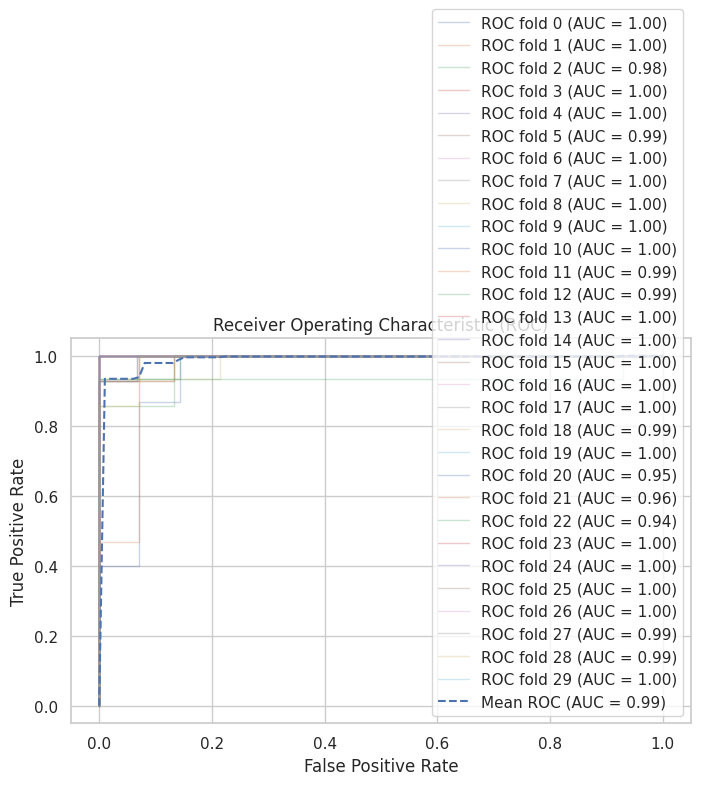

Accuracy (Avg. +/- Std.) is 0.956 +/- 0.042
Sensitivity (Avg. +/- Std.) is 0.968 +/- 0.047
Specificity (Avg. +/- Std.) is 0.944 +/- 0.067
Precision (Avg. +/- Std.) is 0.949 +/- 0.056
FOR (Avg. +/- Std.) is 0.032 +/- 0.045
DOR (Avg. +/- Std.) is inf +/- nan


In [29]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_ensemble = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    # Create and fit the CatBoost classifier
    catboost = CatBoostClassifier(iterations=900, learning_rate=0.05, depth=5, l2_leaf_reg=3, loss_function='Logloss', verbose=0, random_seed=69)
    catboost.fit(X_Train, Y_Train)

    # Create and fit the XGBoost classifier
    xgboost = xgb.XGBClassifier(n_estimators=20000, learning_rate=0.09, max_depth=3, random_state=69)
    xgboost.fit(X_Train, Y_Train)

    # Create a Voting Classifier
    ensemble = VotingClassifier(estimators=[
        ('catboost', catboost),
        ('xgboost', xgboost)
    ], voting='soft')

    ensemble.fit(X_Train, Y_Train)

    ensemble_proba = ensemble.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (ensemble_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, ensemble_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_ensemble.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (ensemble_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))


results.append({
        "Model Algorithm Name": "XG AND CATEGORICAL BOOSTING",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

XG BOOSTING AND RANDOM FOREST

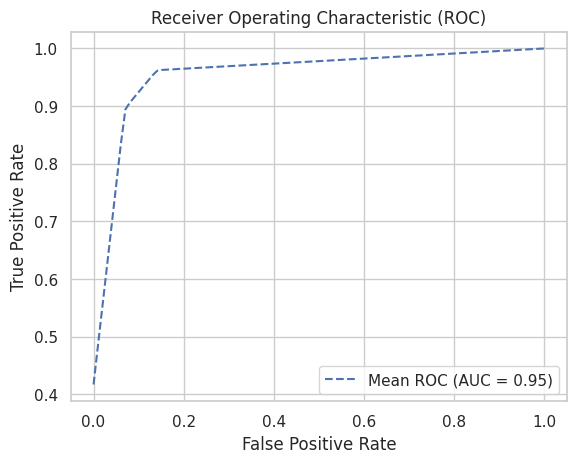

Accuracy (Avg. +/- Std.) is 0.955 +/- 0.036
Sensitivity (Avg. +/- Std.) is 0.959 +/- 0.049
Specificity (Avg. +/- Std.) is 0.951 +/- 0.048
Precision (Avg. +/- Std.) is 0.954 +/- 0.045
FOR (Avg. +/- Std.) is 0.040 +/- 0.047
DOR (Avg. +/- Std.) is inf +/- nan


In [30]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import matplotlib.pyplot as plt

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
sn = []  # Initialize the sensitivity list
sp = []  # Initialize the specificity list
pr = []  # Initialize the precision list
FOR = []  # Initialize the False Omission Rate list
DOR = []  # Initialize the Diagnostic Odds Ratio list
iterator = 0
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    xgboost = XGBClassifier(n_estimators=20000, learning_rate=0.09, max_depth=3, random_state=69)
    xgboost.fit(X_Train, Y_Train)

    # Create and fit the Random Forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=69)
    rf.fit(X_Train, Y_Train)

    ensemble = VotingClassifier(estimators=[('xgboost', xgboost), ('rf', rf)], voting='hard')
    ensemble.fit(X_Train, Y_Train)
    y_pred_ensemble = ensemble.predict(X_Test)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, y_pred_ensemble)
    Accuracy.append(accuracy)

    # Calculate TP, TN, FP, FN
    tn, fp, fn, tp = confusion_matrix(Y_Test, y_pred_ensemble).ravel()
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate sensitivity, specificity, precision, FOR, DOR
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    for_ = fn / (fn + tn)
    dor = (tp / fn) / (fp / tn)

    sn.append(sensitivity)
    sp.append(specificity)
    pr.append(precision)
    FOR.append(for_)
    DOR.append(dor)

    fpr, tpr, thresholds = roc_curve(Y_Test, y_pred_ensemble)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
    "Model Algorithm Name": "XG AND RANDOM FOREST",
    "Accuracy": np.mean(Accuracy),
    "Sensitivity": np.mean(sn),
    "Specificity": np.mean(sp),
    "Precision": np.mean(pr),
    "FOR": np.mean(FOR),
    "DOR": np.mean(DOR),
})


XG BOOST AND K NEAREST NEIGHBOR

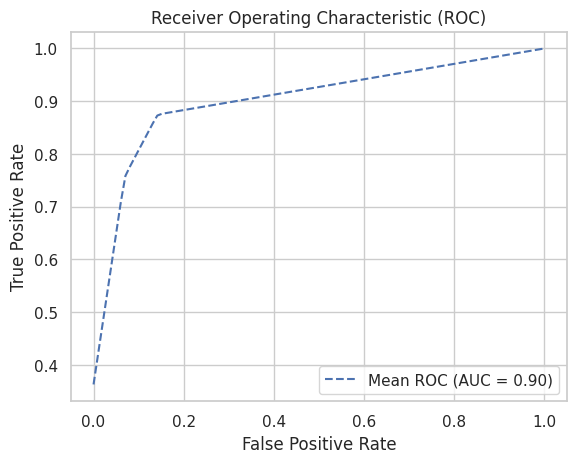

Accuracy (Avg. +/- Std.) is 0.903 +/- 0.063
Sensitivity (Avg. +/- Std.) is 0.866 +/- 0.090
Specificity (Avg. +/- Std.) is 0.939 +/- 0.057
Precision (Avg. +/- Std.) is 0.936 +/- 0.059
FOR (Avg. +/- Std.) is 0.121 +/- 0.076
DOR (Avg. +/- Std.) is inf +/- nan


In [31]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

n_splits = 30
Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    xgboost = XGBClassifier(n_estimators=20000, learning_rate=0.09, max_depth=3, random_state=69)
    xgboost.fit(X_Train, Y_Train)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_Train, Y_Train)

    ensemble = VotingClassifier(estimators=[('xgboost', xgboost), ('knn', knn)], voting='hard')
    ensemble.fit(X_Train, Y_Train)
    y_pred_ensemble = ensemble.predict(X_Test)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, y_pred_ensemble)
    Accuracy.append(accuracy)

    # Calculate TP, TN, FP, FN
    tn, fp, fn, tp = confusion_matrix(Y_Test, y_pred_ensemble).ravel()
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate sensitivity, specificity, precision, FOR, DOR
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    for_ = fn / (fn + tn)
    dor = (tp / fn) / (fp / tn)

    sn.append(sensitivity)
    sp.append(specificity)
    pr.append(precision)
    FOR.append(for_)
    DOR.append(dor)

    fpr, tpr, thresholds = roc_curve(Y_Test, y_pred_ensemble)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    iterator += 1


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "XG BOOSTING AND K NEAREST NEIGHBOR",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

CATEGORICAL BOOSTING AND K NEAREST NEIGHBOR

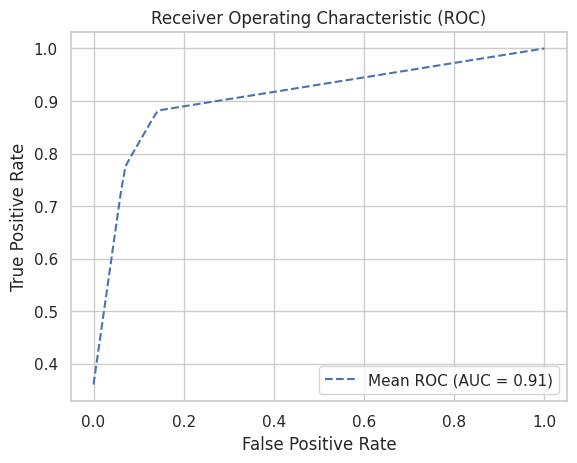

Accuracy (Avg. +/- Std.) is 0.907 +/- 0.056
Sensitivity (Avg. +/- Std.) is 0.872 +/- 0.084
Specificity (Avg. +/- Std.) is 0.942 +/- 0.055
Precision (Avg. +/- Std.) is 0.939 +/- 0.056
FOR (Avg. +/- Std.) is 0.115 +/- 0.069
DOR (Avg. +/- Std.) is inf +/- nan


In [32]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

n_splits = 30
Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    # Create and fit the CatBoost classifier
    catboost = CatBoostClassifier(iterations=900, learning_rate=0.05, depth=5, l2_leaf_reg=3, loss_function='Logloss', verbose=0, random_seed=69)
    catboost.fit(X_Train, Y_Train)

    # Create and fit the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
    knn.fit(X_Train, Y_Train)

    # Ensemble the classifiers using majority vote
    ensemble = VotingClassifier(estimators=[('catboost', catboost), ('knn', knn)], voting='hard')
    ensemble.fit(X_Train, Y_Train)
    y_pred_ensemble = ensemble.predict(X_Test)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, y_pred_ensemble)
    Accuracy.append(accuracy)

    # Calculate TP, TN, FP, FN
    tn, fp, fn, tp = confusion_matrix(Y_Test, y_pred_ensemble).ravel()
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate sensitivity, specificity, precision, FOR, DOR
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    for_ = fn / (fn + tn)
    dor = (tp / fn) / (fp / tn)

    sn.append(sensitivity)
    sp.append(specificity)
    pr.append(precision)
    FOR.append(for_)
    DOR.append(dor)

    fpr, tpr, thresholds = roc_curve(Y_Test, y_pred_ensemble)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr = np.array(mean_tpr)  # Convert to a NumPy array
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "CATEGORICAL BOOSTING AND K NEAREST NEIGHBOR",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})


CATEGORICAL BOOSTING AND RANDOM FOREST

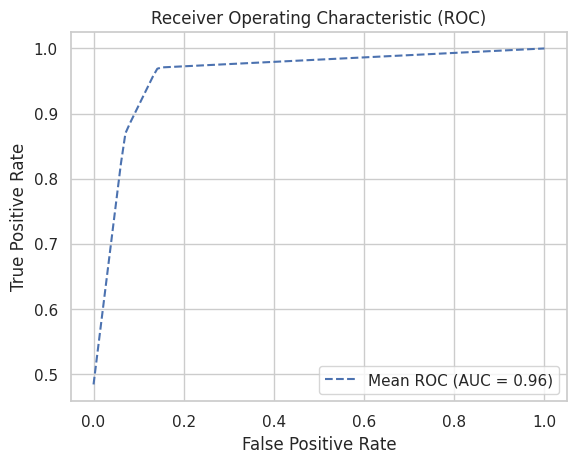

Accuracy (Avg. +/- Std.) is 0.959 +/- 0.034
Sensitivity (Avg. +/- Std.) is 0.967 +/- 0.044
Specificity (Avg. +/- Std.) is 0.951 +/- 0.055
Precision (Avg. +/- Std.) is 0.955 +/- 0.049
FOR (Avg. +/- Std.) is 0.031 +/- 0.040
DOR (Avg. +/- Std.) is inf +/- nan


In [41]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

n_splits = 30
Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
mean_fpr = np.linspace(0, 1, 100)  # Mean false positive rate

kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    # Create and fit the CatBoost classifier
    catboost = CatBoostClassifier(iterations=900, learning_rate=0.05, depth=5, l2_leaf_reg=3, loss_function='Logloss', verbose=0, random_seed=69)
    catboost.fit(X_Train, Y_Train)

    # Create and fit the Random Forest classifier
    rf = RandomForestClassifier(n_estimators=350, random_state=69)  # You can adjust hyperparameters
    rf.fit(X_Train, Y_Train)

    # Ensemble the classifiers using majority vote
    ensemble = VotingClassifier(estimators=[('catboost', catboost), ('rf', rf)], voting='hard')
    ensemble.fit(X_Train, Y_Train)
    y_pred_ensemble = ensemble.predict(X_Test)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, y_pred_ensemble)
    Accuracy.append(accuracy)

    # Calculate TP, TN, FP, FN
    tn, fp, fn, tp = confusion_matrix(Y_Test, y_pred_ensemble).ravel()
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate sensitivity, specificity, precision, FOR, DOR
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    for_ = fn / (fn + tn)
    dor = (tp/fn) / (fp/tn)

    sn.append(sensitivity)
    sp.append(specificity)
    pr.append(precision)
    FOR.append(for_)
    DOR.append(dor)

    fpr, tpr, thresholds = roc_curve(Y_Test, y_pred_ensemble)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    iterator += 1


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "CATEGORICAL BOOSTING AND RANDOM FOREST",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

In [42]:
pip install tabulate

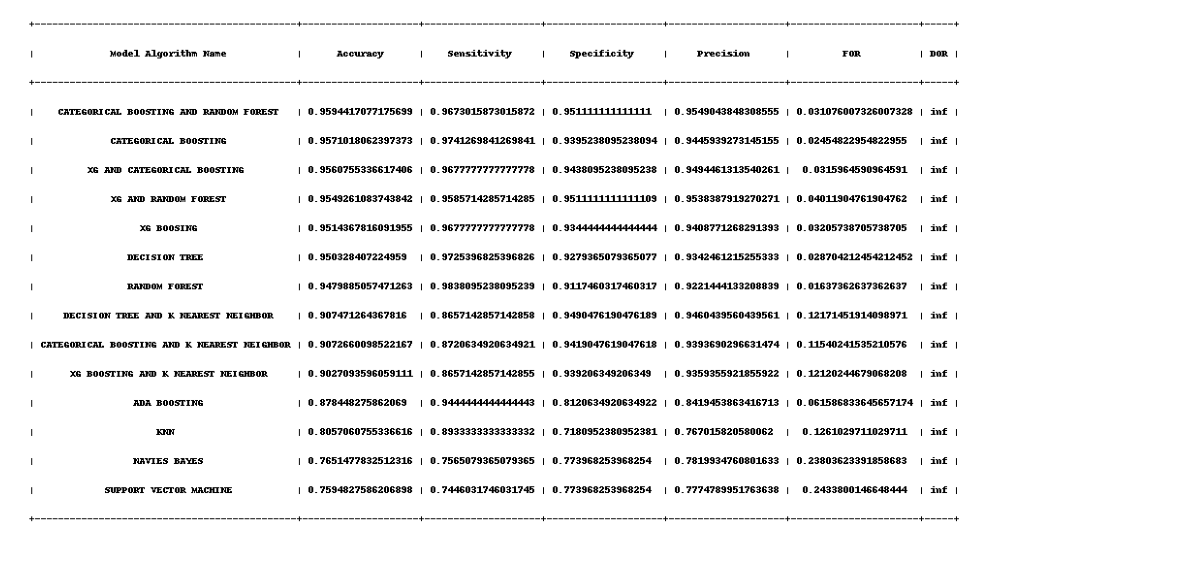

In [43]:
from prettytable import PrettyTable
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Create a PrettyTable instance with column names
table = PrettyTable()
table.field_names = ["Model Algorithm Name", "Accuracy", "Sensitivity", "Specificity", "Precision", "FOR", "DOR"]

for result in results:
    sensitivity = result.get("Sensitivity", "N/A")
    specificity = result.get("Specificity", "N/A")
    precision = result.get("Precision", "N/A")
    for_ = result.get("FOR", "N/A")
    dor = result.get("DOR", "N/A")

    table.add_row([result["Model Algorithm Name"], result["Accuracy"], sensitivity, specificity, precision, for_, dor])

# Sort the table by accuracy in descending order
table.sortby = "Accuracy"
table.reversesort = True

# Get the table as a string
table_str = str(table)

# Split the table into rows
rows = table_str.split('\n')

# Set up the image
font_size = 14
line_height = 30
image_width = 1200  # Increase the image width
image_height = (len(rows) + 1) * line_height
image = Image.new("RGB", (image_width, image_height), "white")
draw = ImageDraw.Draw(image)

# Use a default system font
font = ImageFont.load_default()

# Define text positions
x_position = 20
y_position = 10

# Draw each row in the image
for row in rows:
    draw.text((x_position, y_position), row, fill="black", font=font)
    y_position += line_height

# Save the image with higher resolution
image.save("table_image.png", dpi=(300, 300))  # Set a higher DPI

# Display the image using Matplotlib
plt.figure(figsize=(15, 8))
plt.imshow(image)
plt.axis('off')
plt.show()
